In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from collections import Counter

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input

### Сначала считаем датасеты и посмотрим, какие данные в них представлены

In [2]:
ratings = pd.read_csv('./ml-latest/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
...,...,...,...,...
27753439,283228,8542,4.5,1379882795
27753440,283228,8712,4.5,1379882751
27753441,283228,34405,4.5,1379882889
27753442,283228,44761,4.5,1354159524


In [3]:
tags = pd.read_csv('./ml-latest/tags.csv')
tags

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
...,...,...,...,...
1108992,283206,73017,fun,1264379059
1108993,283206,73017,homoerotic subtext,1264379058
1108994,283206,73017,pacing,1264379058
1108995,283206,73017,plot,1264379058


In [4]:
movies = pd.read_csv('./ml-latest/movies.csv')
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [5]:
links = pd.read_csv('./ml-latest/links.csv')
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
58093,193876,38566,78251.0
58094,193878,1754787,87558.0
58095,193880,5847740,422666.0
58096,193882,4453756,454439.0


In [6]:
genome_scores = pd.read_csv('./ml-latest/genome-scores.csv')
genome_scores

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000
...,...,...,...
14862523,187595,1124,0.10700
14862524,187595,1125,0.05850
14862525,187595,1126,0.03800
14862526,187595,1127,0.10225


In [7]:
genome_tags = pd.read_csv('./ml-latest/genome-tags.csv')
genome_tags

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


### Посмотрим краткую информацию по датасетам, с которыми будем работать впоследствии

#### Начнем с датасета ratings

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [9]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [10]:
ratings.rating.nunique()

10

In [11]:
ratings.rating.value_counts()

4.0    7394710
3.0    5515668
5.0    4071135
3.5    3404360
4.5    2373550
2.0    1850627
2.5    1373419
1.0     886233
0.5     442388
1.5     441354
Name: rating, dtype: int64

(array([ 442388.,  886233.,  441354., 1850627., 1373419., 5515668.,
        3404360., 7394710., 2373550., 4071135.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

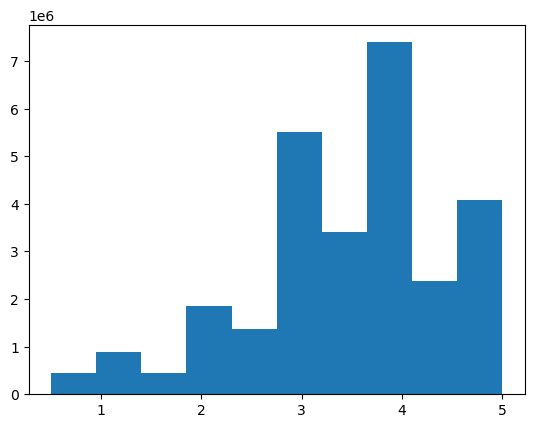

In [12]:
plt.hist(ratings.rating)

Можем сделать вывод, что наиболее частой оценкой является 4.
Также пользователи чаще ставят в качестве рейтинга целые числа, а не дробные.

### Теперь посмотрим на movies

In [13]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [14]:
movies.title.nunique()

58020

In [15]:
movies.title.value_counts()

Slow Burn (2000)                                            2
Blackout (2007)                                             2
20,000 Leagues Under the Sea (1997)                         2
Beneath (2013)                                              2
Deranged (2012)                                             2
                                                           ..
Euridice BA 2O37 (Evridiki BA 2O37) (1975)                  1
Stoplight Society, The (La Sociedad del Semáforo) (2010)    1
Flying Fleet, The (1929)                                    1
Savages (2012)                                              1
Leal (2018)                                                 1
Name: title, Length: 58020, dtype: int64

In [16]:
movies.genres.nunique()

1643

In [17]:
movies.genres.value_counts()

Drama                                      8402
Comedy                                     5372
(no genres listed)                         4266
Documentary                                4250
Comedy|Drama                               2212
                                           ... 
Action|Adventure|Animation|Drama|Sci-Fi       1
Drama|Fantasy|Horror|Mystery|Romance          1
Film-Noir|Thriller|War                        1
Comedy|Musical|Romance|War                    1
Adventure|Animation|Crime                     1
Name: genres, Length: 1643, dtype: int64

То есть, некоторые фильмы повторяются в датасете 2 раза. Определенные комбинации фильмов повторяются достаточно часто, но мы
не можем пока что точно утверждать о частоте использования каждого отдельно жанра. Также 3 по частоте использования место 
занимает '(no genres listed)'. Мы не будем пока предпринимать никаких действий касательно заполнения такого рода пропущенных значений.

#### Посмотрим на tags

In [18]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108997 entries, 0 to 1108996
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1108997 non-null  int64 
 1   movieId    1108997 non-null  int64 
 2   tag        1108981 non-null  object
 3   timestamp  1108997 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 33.8+ MB


In [19]:
tags.describe()

,userId,movieId,timestamp
count,1.108997e+06,1.108997e+06,1.108997e+06
mean,1.248016e+05,5.492109e+04,1.413544e+09
std,7.726964e+04,5.618123e+04,1.144358e+08
min,1.400000e+01,1.000000e+00,1.135429e+09
25%,7.340600e+04,3.362000e+03,1.323903e+09
50%,1.030130e+05,4.374400e+04,1.446994e+09
75%,1.883600e+05,9.682100e+04,1.525549e+09
max,2.832210e+05,1.938680e+05,1.537945e+09


In [20]:
tags.tag.nunique()

74714

In [21]:
tags.tag.value_counts()

sci-fi                 9400
atmospheric            6430
action                 6219
comedy                 5923
surreal                5299
                       ... 
Thirlling Climax          1
netwatch                  1
hateuscuztheyaintus       1
addium                    1
rachel mcadams            1
Name: tag, Length: 74714, dtype: int64

Теги не являются уникальными, а некоторые повторяются достаточно часто, что нам пригодится в дальнейшем

#### Перейдем к genome_scores

In [22]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14862528 entries, 0 to 14862527
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 340.2 MB


In [23]:
genome_scores.describe()

,movieId,tagId,relevance
count,1.486253e+07,1.486253e+07,1.486253e+07
mean,3.997087e+04,5.645000e+02,1.153631e-01
std,4.814930e+04,3.256254e+02,1.554320e-01
min,1.000000e+00,1.000000e+00,2.500000e-04
25%,3.680750e+03,2.827500e+02,2.300000e-02
50%,7.880000e+03,5.645000e+02,5.450000e-02
75%,7.124900e+04,8.462500e+02,1.390000e-01
max,1.875950e+05,1.128000e+03,1.000000e+00


(array([9924602., 2417411., 1051259.,  547594.,  328427.,  208258.,
         145213.,  104158.,   74218.,   61388.]),
 array([2.50000e-04, 1.00225e-01, 2.00200e-01, 3.00175e-01, 4.00150e-01,
        5.00125e-01, 6.00100e-01, 7.00075e-01, 8.00050e-01, 9.00025e-01,
        1.00000e+00]),
 <BarContainer object of 10 artists>)

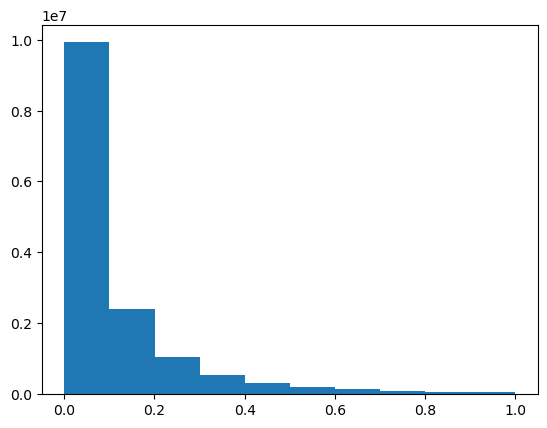

In [24]:
plt.hist(genome_scores.relevance)

Делаем вывод, что большинство пользовательских тегов не являются релевантными 

#### Посмотрим на genome_tags

In [25]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [26]:
genome_tags.tag.nunique()

1128

In [27]:
genome_tags.tag.value_counts()

007                                    1
oscar (best directing)                 1
oscar (best picture)                   1
oscar (best music - original song)     1
oscar (best music - original score)    1
                                      ..
father daughter relationship           1
father son relationship                1
father-son relationship                1
fbi                                    1
zombies                                1
Name: tag, Length: 1128, dtype: int64

Видим, что все теги являются уникальными

### Поработаем отдельно с датасетом movies
1. Добавим новую колонку 'year' и, соответственно, уберем год выпуска из названия фильма.
2. Преобразуем столбец 'genres' таким образом, чтобы каждый из перечисленных в комбинации жанров был самостоятельно валидным. 

In [28]:
movies_with_year = movies.copy(deep=True)
movies_with_year

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy
58095,193880,Her Name Was Mumu (2016),Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi


In [29]:
movies_with_year["year"] = movies_with_year["title"].str.extract(".*\((.*)\).*", expand=False)
movies_with_year

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,2011
58095,193880,Her Name Was Mumu (2016),Drama,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,2017


In [30]:
movies_with_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
 3   year     57776 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [31]:
movies_with_year[movies_with_year['year'].isna()]

,movieId,title,genres,year
10023,32930,Category 6: Day of Destruction,Action|Drama,NaN
10613,40697,Babylon 5,Sci-Fi,NaN
24089,112406,Brazil: In the Shadow of the Stadiums,Documentary,NaN
24344,113190,Slaying the Badger,Documentary,NaN
24885,115133,Tatort: Im Schmerz geboren,Crime,NaN
...,...,...,...,...
57504,192339,The Sign of Three,(no genres listed),NaN
57674,192829,Parwaaz Hai Junoon,Adventure|Children|Romance,NaN
57789,193149,¿Qué te juegas?,(no genres listed),NaN
57903,193443,Wall,(no genres listed),NaN


In [32]:
movies_with_year['year'] = movies_with_year['year'].fillna(0)

In [33]:
movies_with_year[movies_with_year['year'].isna()]

,movieId,title,genres,year


Так как после отделения года выпуска из названия фильма выяснилось, что не у всех фильмов были указаны годы выпуска, мы получили
и значения NaN, которые затем заполнили нулями.

In [34]:
movies_year_title = movies_with_year.copy(deep=True)
movies_year_title

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),1946
58094,193878,Les tribulations d'une caissière (2011),Comedy,2011
58095,193880,Her Name Was Mumu (2016),Drama,2016
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,2017


In [35]:
movies_year_title['title'] = movies_year_title['title'].str.replace('(\(\d\d\d\d\))', '')
movies_year_title

C:\Users\User\AppData\Local\Temp\ipykernel_21548\2274239057.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_year_title['title'] = movies_year_title['title'].str.replace('(\(\d\d\d\d\))', '')


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka,(no genres listed),1946
58094,193878,Les tribulations d'une caissière,Comedy,2011
58095,193880,Her Name Was Mumu,Drama,2016
58096,193882,Flora,Adventure|Drama|Horror|Sci-Fi,2017


In [36]:
movies_year_title_genre = movies_year_title.copy(deep=True)
movies_year_title_genre

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
58093,193876,The Great Glinka,(no genres listed),1946
58094,193878,Les tribulations d'une caissière,Comedy,2011
58095,193880,Her Name Was Mumu,Drama,2016
58096,193882,Flora,Adventure|Drama|Horror|Sci-Fi,2017


In [37]:
movies_year_title_genre['genres'] = movies_year_title_genre['genres'].str.split('|')
movies_year_title_genre

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946
58094,193878,Les tribulations d'une caissière,[Comedy],2011
58095,193880,Her Name Was Mumu,[Drama],2016
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017


In [38]:
movies_complete = movies_year_title_genre.copy(deep=True)
movies_complete

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995
...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946
58094,193878,Les tribulations d'une caissière,[Comedy],2011
58095,193880,Her Name Was Mumu,[Drama],2016
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017


In [39]:
for i, mc_row in movies_complete.iterrows():
    for genre in mc_row['genres']:
        movies_complete.loc[i, genre] = 1

In [40]:
movies_complete

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,NaN,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Father of the Bride Part II,[Comedy],1995,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
58094,193878,Les tribulations d'une caissière,[Comedy],2011,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58095,193880,Her Name Was Mumu,[Drama],2016,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
movies_complete = movies_complete.rename(columns={'(no genres listed)': 'No-Genre'})
movies_complete = movies_complete.fillna(0)
movies_complete

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,[(no genres listed)],1946,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58094,193878,Les tribulations d'une caissière,[Comedy],2011,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,193880,Her Name Was Mumu,[Drama],2016,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,193882,Flora,"[Adventure, Drama, Horror, Sci-Fi]",2017,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
train_ds = movies_complete.copy(deep=True)
train_ds = train_ds.drop(['genres'], axis=1)
train_ds

,movieId,title,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,No-Genre
0,1,Toy Story,1995,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,1995,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,1995,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,1995,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,1995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58093,193876,The Great Glinka,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
58094,193878,Les tribulations d'une caissière,2011,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,193880,Her Name Was Mumu,2016,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,193882,Flora,2017,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Сделаем новый датасет, где каждому пользователю соответсвуют оцененные фильмы, отберем некоторое количество наиболее часто повторяющихся и объединим с train_ds

In [72]:
id_user_num = ratings['userId']
id_user_num = id_user_num.drop_duplicates()
id_user_num = id_user_num.tolist();

In [73]:
id_movie_num = movies['movieId']
id_movie_num = id_movie_num.drop_duplicates()
id_movie_num = id_movie_num.tolist();

In [127]:
ratings.userId.nunique()

283228

In [128]:
ratings.movieId.nunique()

53889

In [133]:
df = ratings.copy()
df = df.drop(['timestamp'], axis=1)
df

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5
...,...,...,...
27753439,283228,8542,4.5
27753440,283228,8712,4.5
27753441,283228,34405,4.5
27753442,283228,44761,4.5


In [103]:
map = {k:i for i, k in enumerate(id_user_num)}
df['userId'] = df['userId'].map(map)

In [104]:
map = {k:i for i, k in enumerate(id_movie_num)}
df['movieId'] = df['movieId'].map(map)

In [105]:
df

,userId,movieId,rating
0,0,304,3.5
1,0,477,3.5
2,0,1069,1.5
3,0,1229,4.5
4,0,1414,4.5
...,...,...,...
27753439,283227,7885,4.5
27753440,283227,8029,4.5
27753441,283227,10304,4.5
27753442,283227,10964,4.5


In [140]:
df = pd.merge(df, train_ds, how='left', on='movieId')

In [ ]:
df = df.drop(['title'], axis=1)
df

In [129]:
user_count = Counter(df['userId'])
user_id = [user for user, c in user_count.most_common(18000)]

In [130]:
movies_count = Counter(df['movieId'])
movie_id = [movie for movie, c in movies_count.most_common(40000)]

In [134]:
fin_df = df[df['userId'].isin(user_id) & df['movieId'].isin(movie_id)]
fin_df

,userId,movieId,rating
31,3,640,3.0
32,3,828,4.0
33,3,960,3.0
34,3,1221,4.0
35,3,1321,4.0
...,...,...,...
27750030,283194,457,3.0
27750031,283194,480,3.0
27750032,283194,590,3.0
27750033,283194,593,3.0


### Разделим данные на тренировочную и тестовую выборки и создадим нашу модель

In [ ]:
split = int(0.75 * len(df))

In [ ]:
train_df = fin_df.iloc[:split, :]
test_df = fin_df.iloc[split:, :]

In [ ]:
n = 100
user_num = 18000
movie_num = 40000

In [115]:
model = Sequential()

model.add(Input(shape=(1, 1)))
model.add(Embedding(5000, 50))